# Loading Deepmind's Diplomacy trajectory

In [ ]:
import numpy as np

In [ ]:
action_outputs = np.load(file='../data/actions_outputs.npz', allow_pickle=True)

In [ ]:
action_outputs[1][0]

In [ ]:
import pandas as pd

In [ ]:
pd.DataFrame.from_dict(action_outputs[0][0]).corr(method='pearson')

In [ ]:
legal_actions = np.load(file='../data/legal_actions.npz', allow_pickle=True)

In [ ]:
len(legal_actions)

In [ ]:
legal_actions[0].shape

In [ ]:
observations = np.load(file='../data/observations.npz', allow_pickle=True)

In [ ]:
len(observations)

In [ ]:
observations[1]

In [ ]:
step_outputs = np.load(file='../data/step_outputs.npz', allow_pickle=True)

In [ ]:
len(step_outputs)

In [ ]:
step_outputs[0]

# Loading human plays' data

In [ ]:
import json
import pandas as pd
import mmap

In [ ]:
# games_jsons = []
# ix = 0
# with open("../data/diplomacy-v1-27k-msgs/standard_no_press.jsonl", "r") as json_file:
#     for line in json_file:
#         games_jsons.append(json.loads(line))

In [ ]:
# Load the json data
games_jsons = []
with open("../data/diplomacy-v1-27k-msgs/standard_no_press.jsonl", "r+b") as json_file:
    with mmap.mmap(json_file.fileno(), length=0, access=mmap.ACCESS_READ) as mmap_object:
        for i, line in enumerate(iter(mmap_object.readline, b"")):
            games_jsons.append(json.loads(line.decode("utf-8")))
            if i == 20:
                break

## Uncomment to load RL single game data

In [ ]:

# games_jsons = []
# json_file_path = "../data/game_rl_0.json"

# with open(json_file_path, 'r') as j:
#       games_jsons.append(json.loads(j.read()))

In [ ]:
# Convert to a pandas dataframe
df = pd.DataFrame(games_jsons)

In [ ]:
df = df[df["map"] == "standard"].reset_index(drop=True)

In [ ]:
df

In [ ]:
games = df['phases']

In [ ]:
games.apply(lambda x: x[0])

In [ ]:
type(games)

In [ ]:
for game in games:
    for ix, iy in enumerate(game):
        game[ix]['phase_id'] = ix

In [ ]:
def flatten_json(input):
    out = {}
    out['game_id'] = input['state']['game_id']
    out['phase_id'] = input['phase_id']
    out['phase_name'] = input['name']
    results_units_keys = [x for x in input['results']]

    assert input['orders'].items() 
    for player, orders in input['orders'].items():
        if orders is not None:
            if orders:
                for order in orders:
                    out['coordinator'] = player
                    out['type'] = order.split()[0]
                    out['current_location'] = order.split()[1]
                    out['action'] = order.split()[2]
                    unit = order.split()[0]+ ' ' + order.split()[1]
                    # print("unit result is: ", unit , unit in results_units, results_units)
                    if input['results']:
                        out['results'] = input['results'][unit]
                    else:
                        print("empty results")
                        print(order)
                    if unit in results_units_keys:
                        results_units_keys.remove(unit)
                    out['impact_location'] = []
                    if out['action'] == '-' or out['action'] == 'R':
                        assert len(order.split()) == 4 or len(order.split()) == 5, order
                        out['impact_location'] = order.split()[3]
                    yield(out)
                else:
                    out['coordinator'] = player
                    out['type'] = -1
                    out['current_location'] = -1
                    out['action'] = -1
                    out['results'] = -1
                    out['impact_location'] = -1
                    if out['action'] == '-' or out['action'] == 'R':
                        assert len(order.split()) == 4 or len(order.split()) == 5, order
                        out['impact_location'] = order.split()[3]
                    yield(out)
            else:
                # we have non eorders, is that a problem ?
                pass

    if len(results_units_keys)>0:
        for unit in results_units_keys:
            if unit == 'WAIVE': ## FIXME: double check this later
                continue
            assert len(unit.split()) == 2, unit
            out['coordinator'] = 'RA'
            for player in input["state"]["units"]:
                if unit in input["state"]["units"][player]:
                    out['coordinator'] = player

            if len(unit.split()[0]) != 1: # if we have sth like HOL D: "void"
                assert input['results'][unit][0] == 'void', input['results'][unit]
                location = unit.split()[0]
                assert unit.split()[1] == 'D', unit.split()[1]
                # find the corresponding key in the results
                for key in input['results']:
                    if key.split()[1] == location:
                        assert input['results'][key][0] == "disband", input['results'][key]
                        input['results'][key].append(input['results'][unit][0])
                        break
            else:
                out['type'] = unit.split()[0]
                out['current_location'] = unit.split()[1]
                out['results'] = input['results'][unit]
                out['action'] = -2
                out['impact_location'] = -2
                yield(out)

In [ ]:
all_records = []
for idx, game in enumerate(games):
  for idx, phase in enumerate(game):
    row_generator = flatten_json(phase)
    assert row_generator is not None, row_generator
    for row in row_generator:
      all_records.append(row.copy())

In [ ]:
complete_df = pd.DataFrame.from_records(all_records)

In [ ]:
complete_df[complete_df['game_id'] == "uXFQ2zgI-DUrgwlS"]

In [ ]:
complete_df[:40]

In [ ]:
complete_df.loc[complete_df['coordinator'] == 'RA']

In [ ]:
complete_df['unique_unit_id'] = -1

## Issues:
- [x] type is incorrect for added rows in the result dict
- [] ids do not start from 1 at the beginning of each game 
- [] NaN orders ... probably order list for player is empty for some reason

# Temporal Binding

In [ ]:
def assign_unit_id(phase_df, source_unit_id_map, dest_unit_id_map, _id):

    # fror each row in the phase df
    for idx, row in phase_df.iterrows():

        # if current location or type of army in invalid skip the row (we only deal with valid orders)
        if row['action'] == -1 or row['type'] == 'N':
            continue
        
        # get the current location of the unit
        source_unit = row['type'] + ' ' + row['current_location']

        # if the location is not in the map, add it to the map (in other phases the same unit can be used, hence checking the condition _ dictionaries are global, have data across phases)
        if source_unit not in source_unit_id_map:
            source_unit_id_map[source_unit] = _id
            _id += 1

        # destination dict is synced with source dict after the loop, so that we can use updated info at the beginning of each assignment
        # row['unique_unit_id'] = source_unit_id_map[source_unit]
        phase_df.loc[idx,'unique_unit_id'] = source_unit_id_map[source_unit]

        if row['action'] == '-':
            result = row['results']
            if isinstance(result, list):
                if len(result) == 0:
                    dest_location = row['impact_location']
                    try:
                        dest_unit = row['type'] + ' ' + dest_location
                    except:
                        print("dest location error", row)
                        return
                    if dest_unit not in dest_unit_id_map:
                        dest_unit_id_map[dest_unit] = source_unit_id_map.pop(source_unit)
                        # source_unit_id_map[source_unit]
                        # print(source_unit_id_map.pop(source_unit))
                elif 'disband' in result:
                    source_unit_id_map.pop(source_unit)
                    
        elif row['action'] == 'R':
            result = row['results']
            if isinstance(result, list):
                if len(result) == 0:
                    dest_location = row['impact_location']
                    dest_unit = row['type'] + ' ' + dest_location
                    if dest_unit not in dest_unit_id_map:
                        dest_unit_id_map[dest_unit] = source_unit_id_map.pop(source_unit)
                elif 'disband' in result:
                    if len(result) > 1:
                        if 'void' in result:
                                print(result)
                    source_unit_id_map.pop(source_unit)

        elif row['action'] == 'D':
            result = row['results']
            assert source_unit in source_unit_id_map
            if isinstance(result, list):
                if len(result) == 0:
                    source_unit_id_map.pop(source_unit)
                elif 'void' in result:
                    print("void disband", row)
        
        elif row['action'] == 'B':
            assert source_unit in source_unit_id_map

        elif row['action'] == 'H':
            assert source_unit in source_unit_id_map

        elif row['action'] == 'S':
            assert source_unit in source_unit_id_map
        
        elif row['action'] == 'C':
            assert source_unit in source_unit_id_map

        # for added result rows
        elif row['action'] == -2:
            result = row['results']
            assert source_unit in source_unit_id_map
            if isinstance(result, list):
                if len(result) == 0:
                    source_unit_id_map.pop(source_unit)
                elif 'disband' in result and 'void' not in result:
                    source_unit_id_map.pop(source_unit)
                    # print("disband")
                elif 'disband' in result and 'void' in result:
                    # print("void disband")
                    pass
        else:
            print("invalid action", row)

    # merge the source and destination dictionaries into one
    source_unit_id_map.update(dest_unit_id_map)
    # remove the destination dict (values get updated based on old data if we don't do this)
    dest_unit_id_map = {}

    return source_unit_id_map, dest_unit_id_map, _id

In [ ]:
unique_games = complete_df["game_id"].unique()

In [ ]:
unique_games

In [ ]:
complete_df.loc[complete_df["game_id"] == 'uXFQ2zgI-DUrgwlS']['phase_id'].unique()

In [ ]:
game_phase_df_list = []
for idx, game_id in enumerate(unique_games):
    print(idx, game_id)
    s_dict = {}
    d_dict = {}
    _id = 1
    unique_phases = complete_df.loc[complete_df["game_id"] == game_id]['phase_id'].unique()
    for phase in unique_phases:
        # print("phase number is", phase)
        condition = (complete_df["game_id"].apply(lambda x: x == game_id)) & (complete_df["phase_id"].apply(lambda x: x == phase))
        phase_df = complete_df.loc[condition]
        s_dict, d_dict, _id = assign_unit_id(phase_df, s_dict, d_dict, _id)
        game_phase_df_list.append(phase_df)

In [ ]:
game_phase_df_list[0]

In [ ]:
# cdf = pd.concat(game_phase_df_list, ignore_index=True)
cdf = pd.concat(game_phase_df_list)

In [ ]:
cdf

In [ ]:
cdf.loc[cdf['coordinator'] == 'RA']

In [ ]:
cdf.loc[cdf['game_id'] == 'lVp6PZxk3Jpufc9Z'][:40].sort_values(by=['phase_id', 'unique_unit_id'])

In [ ]:
unique_games

In [ ]:
tmp = cdf.loc[cdf['game_id'] == "uXFQ2zgI-DUrgwlS"]
# condition = (tmp["phase_id"].apply(lambda x: x == 0)) & (tmp["unique_unit_id"].apply(lambda x: x != -1))
spring_fall_phases=(tmp['phase_name'].apply(lambda x:x[0])!='W') & (tmp['phase_name'].apply(lambda x:x[-1])!='R') & (tmp['phase_name'].apply(lambda x:x[-1]) == 'M')
tmp[spring_fall_phases].groupby(["game_id","coordinator","phase_id"])["unique_unit_id"].nunique().unstack().head(8)

In [ ]:
tmp = cdf.loc[cdf['game_id'] == "X9hvE_k6LbQrauYc"]
# condition = (tmp["phase_id"].apply(lambda x: x == 0)) & (tmp["unique_unit_id"].apply(lambda x: x != -1))
spring_fall_phases=(tmp['phase_name'].apply(lambda x:x[0])!='W') & (tmp['phase_name'].apply(lambda x:x[-1])!='R') & (tmp['phase_name'].apply(lambda x:x[-1]) == 'M')
tmp[spring_fall_phases].groupby(["game_id","coordinator","phase_id"])["unique_unit_id"].nunique().unstack().head(8)

In [ ]:
tmp = cdf.loc[cdf['game_id'] == "lVp6PZxk3Jpufc9Z"]
# condition = (tmp["phase_id"].apply(lambda x: x == 0)) & (tmp["unique_unit_id"].apply(lambda x: x != -1))
spring_fall_phases=(tmp['phase_name'].apply(lambda x:x[0])!='W') & (tmp['phase_name'].apply(lambda x:x[-1])!='R') & (tmp['phase_name'].apply(lambda x:x[-1]) == 'M')
tmp[spring_fall_phases].groupby(["game_id","coordinator","phase_id"])["unique_unit_id"].nunique().unstack().head(8)

In [ ]:
tmp = cdf.loc[cdf['game_id'] == "HYc16KDWi8zHNlmn"]
# condition = (tmp["phase_id"].apply(lambda x: x == 0)) & (tmp["unique_unit_id"].apply(lambda x: x != -1))
spring_fall_phases=(tmp['phase_name'].apply(lambda x:x[0])!='W') & (tmp['phase_name'].apply(lambda x:x[-1])!='R') & (tmp['phase_name'].apply(lambda x:x[-1]) == 'M')
tmp[spring_fall_phases].groupby(["game_id","coordinator","phase_id"])["unique_unit_id"].nunique().unstack().head(8)

<AxesSubplot:xlabel='phase_name'>

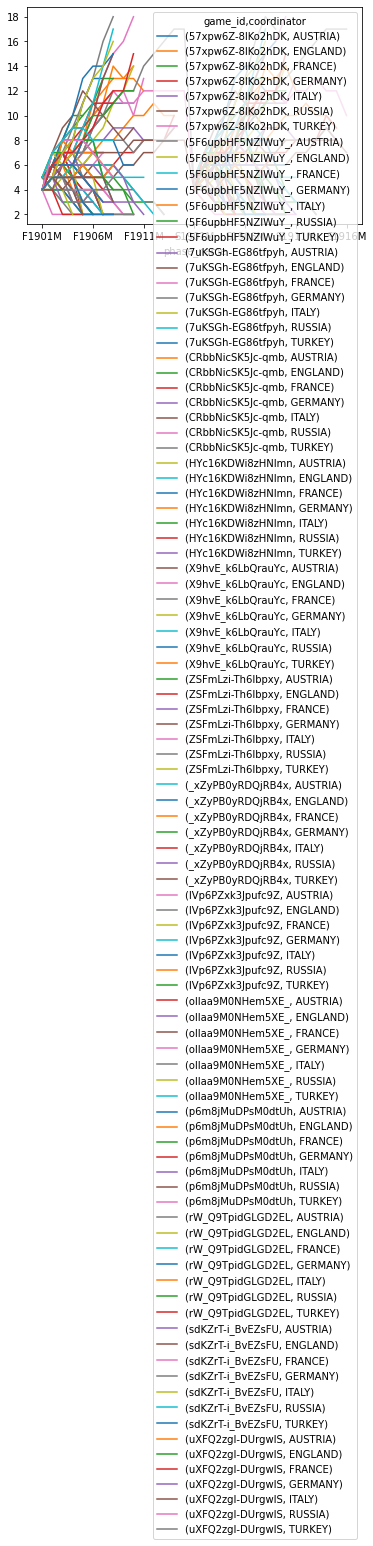

In [120]:
spring_fall_phases=(cdf['phase_name'].apply(lambda x:x[0])!='W') & (cdf['phase_name'].apply(lambda x:x[-1])!='R') & (cdf['phase_name'].apply(lambda x:x[-1]) == 'M')
cdf[spring_fall_phases].groupby(["game_id","coordinator","phase_name"])["unique_unit_id"].nunique().unstack().T.plot()

In [ ]:
cdf[spring_fall_phases].groupby(["game_id","coordinator","phase_name"])["unique_unit_id"].nunique().unstack().head(14)

<AxesSubplot:xlabel='phase_id'>

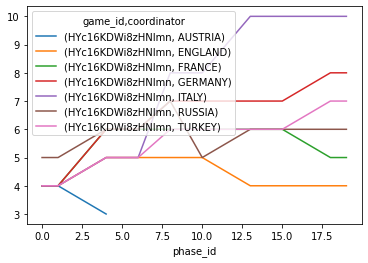

In [119]:
spring_fall_phases=(tmp['phase_name'].apply(lambda x:x[0])!='W') & (tmp['phase_name'].apply(lambda x:x[-1])!='R') & (tmp['phase_name'].apply(lambda x:x[-1]) == 'M')
tmp[spring_fall_phases].groupby(["game_id","coordinator","phase_id"])["unique_unit_id"].nunique().unstack().T.plot()

In [ ]:
len(cdf[spring_fall_phases]["phase_id"].unique())

In [ ]:
len(cdf["phase_id"].unique())

In [ ]:
len(tmp[spring_fall_phases]["phase_id"].unique())

In [ ]:
len(tmp["phase_id"].unique())

In [ ]:
tmp[spring_fall_phases].groupby(["game_id","coordinator","phase_id"])["unique_unit_id"].nunique().unstack().head(8)

In [ ]:
cdf[spring_fall_phases].groupby(["game_id","coordinator","phase_id"])["unique_unit_id"].nunique().unstack().head(8)

In [ ]:
cnd=(cdf['phase_name'].apply(lambda x:x[0])!='W') & (cdf['phase_name'].apply(lambda x:x[-1])!='R') & (cdf['game_id'].apply(lambda x: x == '57xpw6Z-8IKo2hDK') )
# & (cdf['phase_id'].apply(lambda x : x ==5))

In [ ]:
cdf[cnd]

In [ ]:
cdf.groupby(["game_id","coordinator","phase_id"])["unique_unit_id"].nunique().unstack().head(8)

In [ ]:
from pprint import pprint
import json

In [ ]:
cdf[spring_fall_phases].loc[cdf["game_id"] == "57xpw6Z-8IKo2hDK"]

In [ ]:
for game in games_jsons:
    if game['id'] == "7uKSGh-EG86tfpyh":
        json.dump(game, open('7uKSGh-EG86tfpyh.json', 'w'))